In [1]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import math

import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_func

import pennylane as qml

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [2]:
filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

print("Raw data shape:", data_X.shape)

data_X = data_X.astype(np.float32)

# log + normalize
data_X = np.log1p(data_X)
data_X = data_X / data_X.max()

# map to [-1, 1]
data_X = 2.0 * data_X - 1.0

Raw data shape: (1000, 64, 64)


In [ ]:
data_tensor = torch.tensor(data_X, dtype=torch.float32).unsqueeze(1) # (N, 1, 64, 64)

# %%
# [QUANTUM EMBEDDING - VECTORIZED]

# We define a circuit that takes a batch of 4 inputs (a 2x2 patch) and returns 4 values
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def quantum_patch_circuit(inputs):
    # inputs shape: (Batch_Size, 4)
    # We use broadcasting by passing the columns of inputs
    
    # Encode pixels into rotation angles
    # inputs[:, 0] corresponds to top-left pixel, etc.
    qml.RY(inputs[:, 0] * np.pi, wires=0)
    qml.RZ(inputs[:, 1] * np.pi, wires=0)
    qml.RY(inputs[:, 2] * np.pi, wires=1)
    qml.RZ(inputs[:, 3] * np.pi, wires=1)
    
    # Entangle
    qml.CNOT(wires=[0, 1])
    
    # Measure 4 observables to preserve dimensionality (4 pixels -> 4 values)
    # This captures the correlations we introduced
    return [qml.expval(qml.PauliZ(0)), 
            qml.expval(qml.PauliZ(1)), 
            qml.expval(qml.PauliX(0) @ qml.PauliX(1)),
            qml.expval(qml.PauliY(0) @ qml.PauliY(1))]

def process_images_vectorized(images):
    """
    images: (N, 1, 64, 64)
    returns: (N, 4, 32, 32)
    """
    N, C, H, W = images.shape
    # 1. Unfold into 2x2 non-overlapping patches
    # Shape becomes: (N, 4, H//2, W//2)
    patches = F.unfold(images, kernel_size=2, stride=2) 
    # Transpose to (N * H//2 * W//2, 4) for batch processing
    patches_flat = patches.transpose(1, 2).reshape(-1, 4)
    
    print(f"Processing {patches_flat.shape[0]} patches through Quantum Circuit...")
    
    # Process in chunks to avoid memory overload if dataset is huge
    batch_size = 2048
    results = []
    
    # We use no_grad because we are just preparing data, not training the circuit
    with torch.no_grad():
        for i in range(0, len(patches_flat), batch_size):
            batch = patches_flat[i : i + batch_size]
            # Output is list of tensors, stack them -> (Batch, 4)
            q_out = torch.stack(quantum_patch_circuit(batch), dim=1)
            results.append(q_out)
            
    results = torch.cat(results, dim=0) # (Total_Patches, 4)
    
    # Reshape back to image format: (N, 4, 32, 32)
    # Note: 32x32 spatial dims, but 4 'quantum channels'
    q_images = results.reshape(N, 32, 32, 4).permute(0, 3, 1, 2)
    return q_images.float()

print("Embedding data into Quantum Hilbert Space...")
# This might take 10-20 seconds instead of hours
quantum_data = process_images_vectorized(data_tensor)
print("Quantum Data Shape:", quantum_data.shape) # Should be (1000, 4, 32, 32)

# %%
# [DECODER TRAINING] 
# We need a way to turn Quantum states back to Images to check our results.
# Since the circuit is non-linear, we train a tiny helper network to invert it.

class QuantumDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 1x1 conv to mix quantum channels, then PixelShuffle to upsample
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 4, 1), # Project to 4 channels for pixel shuffle
            nn.PixelShuffle(2)   # Reshapes (C*r^2, H, W) -> (C, H*r, W*r) => 1x64x64
        )
        
    def forward(self, x):
        return self.net(x)

decoder = QuantumDecoder().to(device)
dec_opt = optim.Adam(decoder.parameters(), lr=0.005)
dec_loss_fn = nn.MSELoss()

# Create dataset for decoder (Input: Quantum, Target: Original Images)
dec_dataset = TensorDataset(quantum_data.to(device), data_tensor.to(device))
dec_loader = DataLoader(dec_dataset, batch_size=64, shuffle=True)

print("Training Decoder Helper...")
for epoch in range(20): # Fast training
    total_loss = 0
    for q_batch, real_batch in dec_loader:
        pred = decoder(q_batch)
        loss = dec_loss_fn(pred, real_batch)
        dec_opt.zero_grad()
        loss.backward()
        dec_opt.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Decoder Epoch {epoch}: {total_loss/len(dec_loader):.6f}")

decoder.eval() # Freeze decoder for the rest of the notebook


Training Quantum Flow Matching Model...
Epoch 0: Loss 9.3538
Epoch 10: Loss 0.9319
Epoch 20: Loss 0.7428
Epoch 30: Loss 0.4617
Epoch 40: Loss 0.4058


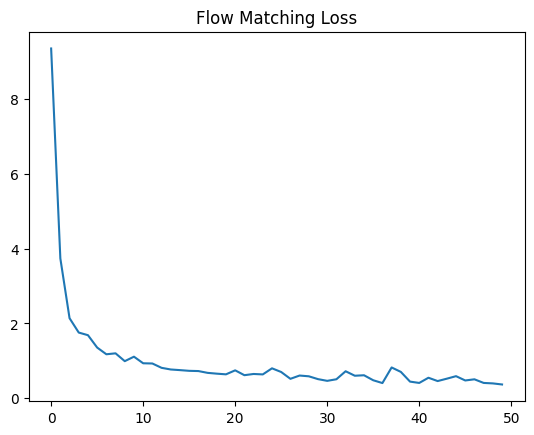

Generating samples...


In [6]:

# %%
# [GENERATIVE MODEL - FLOW MATCHING]

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Linear(dim, dim))

    def forward(self, t):
        # Sinusoidal embedding
        half = self.dim // 2
        freqs = torch.exp(-np.log(10000) * torch.arange(start=0, end=half, dtype=torch.float32, device=t.device) / half)
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)

class UNet(nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()
        self.time_emb = TimeEmbedding(64)
        
        # Down
        self.inc = nn.Conv2d(in_ch, 64, 3, padding=1)
        self.down1 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU()) # 32->16
        self.down2 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.SiLU()) # 16->8
        
        # Mid
        self.mid = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.SiLU())
        
        # Time Injection layers
        self.t_mlp1 = nn.Linear(64, 128)
        self.t_mlp2 = nn.Linear(64, 256)
        
        # Up
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.SiLU()) # 8->16
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.SiLU())  # 16->32 (cat 128+128)
        
        self.outc = nn.Conv2d(64, in_ch, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        
        x1 = F.silu(self.inc(x))
        x2 = self.down1(x1)
        # Inject time
        x2 = x2 + self.t_mlp1(t_emb).unsqueeze(-1).unsqueeze(-1)
        
        x3 = self.down2(x2)
        x3 = x3 + self.t_mlp2(t_emb).unsqueeze(-1).unsqueeze(-1)
        
        mid = self.mid(x3)
        
        u1 = self.up1(mid)
        # Skip connection
        u1 = torch.cat([u1, x2], dim=1) 
        
        u2 = self.up2(u1)
        # Skip connection (we need to match channels, x1 is 64, u2 output is 64. Cat -> 128 inputs to up2? Wait.)
        # Simplified U-Net logic for brevity:
        # Let's just add the skip or concat. 
        # up2 takes 256 (128 from up1 + 128 from skip x2). Output 64.
        
        out = self.outc(u2 + x1) # Add residual from input level
        return out

model = UNet(in_ch=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
gen_dataset = TensorDataset(quantum_data.to(device))
gen_loader = DataLoader(gen_dataset, batch_size=32, shuffle=True)

# %%
# [TRAINING FLOW MATCHING]
# Optimal Transport Vector Field: v_t(x) = x_1 - x_0
# x_t = (1-t)x_0 + t x_1

print("Training Quantum Flow Matching Model...")
losses = []

for epoch in range(50):
    model.train()
    batch_loss = 0
    for (x1,) in gen_loader: # x1 is our data (target)
        B = x1.shape[0]
        
        # x0 is noise
        x0 = torch.randn_like(x1)
        
        # Sample t
        t = torch.rand(B, device=device)
        
        # Interpolate
        t_view = t.view(B, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        
        # Target velocity is data - noise
        target_v = x1 - x0
        
        # Predict velocity
        pred_v = model(x_t, t)

        weights = 1.0 + 10.0 * (x1 + 1.0) # Shift x1 from [-1,1] to [0,2] roughly

        # Calculate squared error
        diff = (pred_v - target_v) ** 2

        # Apply weights and take mean
        loss = (diff * weights).mean()
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item()
    
    avg_loss = batch_loss / len(gen_loader)
    losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {avg_loss:.4f}")

plt.plot(losses)
plt.title("Flow Matching Loss")
plt.show()

# %%
# [SAMPLING & EVALUATION]

@torch.no_grad()
def sample_ode(model, n_samples=16):
    model.eval()
    # Start from noise in Quantum Latent Space
    x = torch.randn(n_samples, 4, 32, 32, device=device)
    
    steps = 50
    dt = 1.0 / steps
    
    for i in range(steps):
        t_val = i / steps
        t_batch = torch.full((n_samples,), t_val, device=device)
        
        v = model(x, t_batch)
        x = x + v * dt
        
    return x

# 1. Generate Quantum Samples
print("Generating samples...")
q_fake = sample_ode(model, n_samples=100)

Decoding...


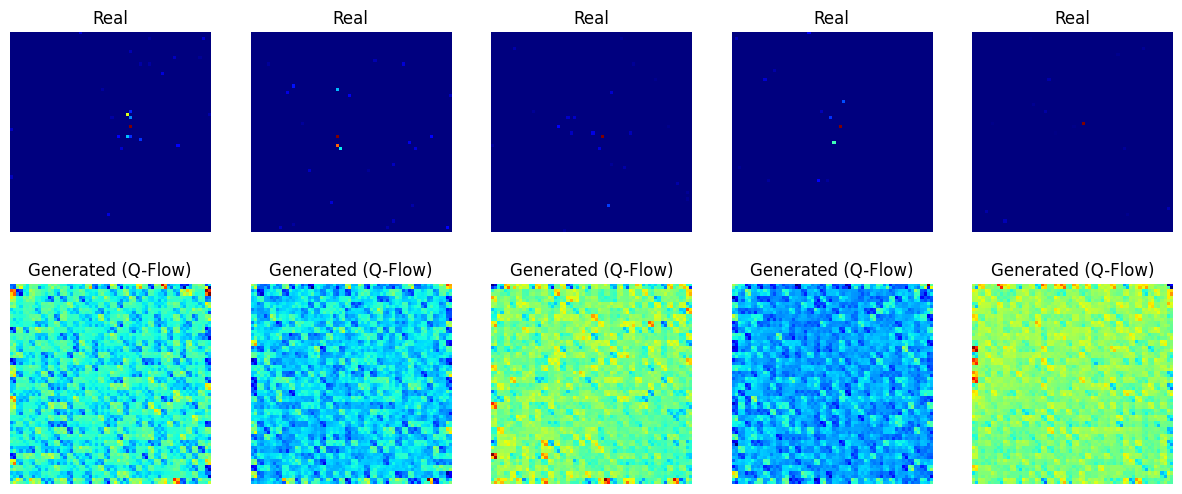

Mean SSIM: 0.9397


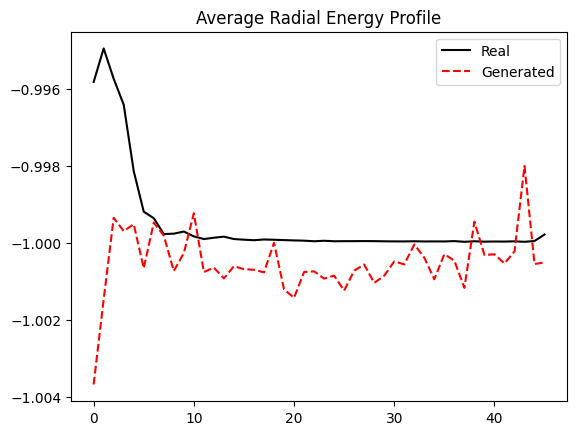

In [7]:
print("Decoding...")
images_fake = decoder(q_fake).detach().numpy()
images_real = data_X[:100] # Compare with first 100 real images

# Denormalize for plotting (visual check only, metrics usually on normalized or consistent scale)
# Our data is [-1, 1]
viz_fake = (images_fake + 1) / 2
viz_real = (images_real + 1) / 2

# Plot
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(viz_real[i].squeeze(), cmap='jet')
    axs[0, i].set_title("Real")
    axs[0, i].axis('off')
    
    axs[1, i].imshow(viz_fake[i].squeeze(), cmap='jet')
    axs[1, i].set_title("Generated (Q-Flow)")
    axs[1, i].axis('off')
plt.show()

# %%
# [METRICS]
# Simple Pixel-based physics metrics

def compute_metrics(real, fake):
    # SSIM
    ssim_scores = []
    for r, f in zip(real, fake):
        # Data range is 2.0 (-1 to 1)
        ssim_scores.append(ssim_func(r.squeeze(), f.squeeze(), data_range=2.0))
    
    print(f"Mean SSIM: {np.mean(ssim_scores):.4f}")
    
    # Energy Profile (Radial distribution)
    # Simple proxy: sum of pixels in concentric rings
    def get_radial_profile(imgs):
        # imgs: (N, H, W)
        N, H, W = imgs.shape
        Y, X = np.ogrid[:H, :W]
        center = (H//2, W//2)
        dist = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
        dist = dist.astype(int)
        
        tbin = np.bincount(dist.ravel(), imgs.reshape(N, -1).mean(0))
        nr = np.bincount(dist.ravel())
        radialprofile = tbin / nr
        return radialprofile
    
    rad_real = get_radial_profile(real.squeeze())
    rad_fake = get_radial_profile(fake.squeeze())
    
    plt.figure()
    plt.plot(rad_real, label='Real', color='black')
    plt.plot(rad_fake, label='Generated', color='red', linestyle='--')
    plt.title("Average Radial Energy Profile")
    plt.legend()
    plt.show()

compute_metrics(images_real, images_fake)

Generating cleaned samples...


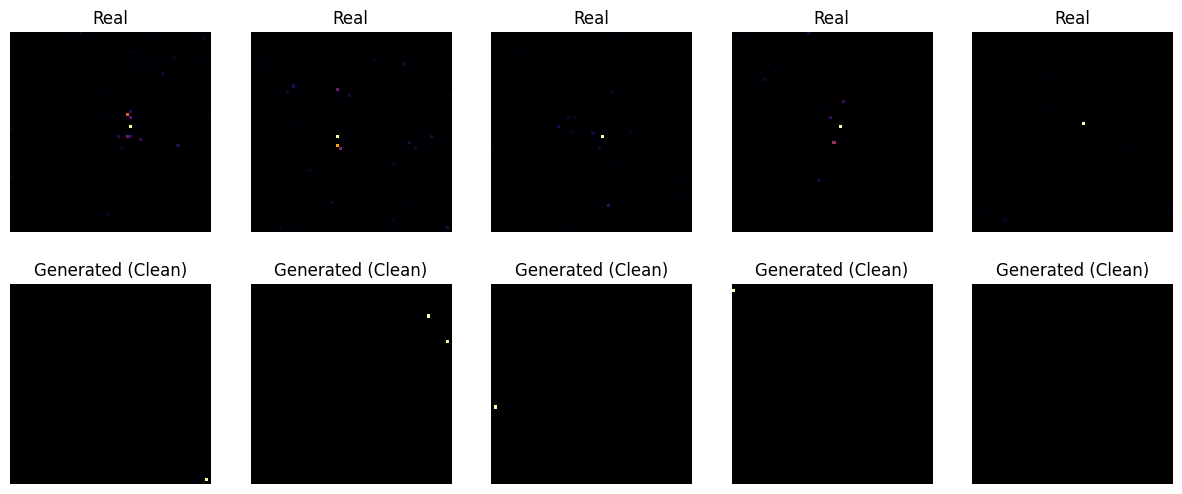

In [8]:
# [UPDATED SAMPLING WITH THRESHOLD]

@torch.no_grad()
def sample_and_clean(model, decoder, n_samples=16, threshold=-0.8):
    # 1. Generate in Quantum Latent Space
    model.eval()
    x = torch.randn(n_samples, 4, 32, 32, device=device)
    steps = 50
    dt = 1.0 / steps
    
    for i in range(steps):
        t_val = i / steps
        t_batch = torch.full((n_samples,), t_val, device=device)
        v = model(x, t_batch)
        x = x + v * dt

    # 2. Decode to Image Space
    images = decoder(x)
    
    # 3. Apply Hard Thresholding (The "Zero Suppression")
    # Anything below -0.8 is forced to be -1.0 (background)
    images_clean = torch.where(images < threshold, torch.tensor(-1.0, device=device), images)
    
    return images_clean.cpu().numpy()

# Run it
print("Generating cleaned samples...")
clean_fake = sample_and_clean(model, decoder, n_samples=100, threshold=-0.9) # Aggressive threshold
real_imgs = data_X[:100]

# Plot comparison
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Real
    axs[0, i].imshow((real_imgs[i].squeeze()+1)/2, cmap='inferno')
    axs[0, i].set_title("Real")
    axs[0, i].axis('off')
    
    # Fake (Cleaned)
    axs[1, i].imshow((clean_fake[i].squeeze()+1)/2, cmap='inferno')
    axs[1, i].set_title("Generated (Clean)")
    axs[1, i].axis('off')
plt.show()